In [1]:
import glob

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from src.classes import BallAnomaly, Boundary
from src.performance_evaluation import (
    center_of_mass,
    compute_position_error,
    compute_volume_error,
    compute_voxel_error,
)
from src.util import plot_voxel, plot_voxel_c, voxel_ball

print(tf.__version__)
import pandas as pd
import seaborn as sns

boundary = Boundary()

2024-04-25 06:41:01.518507: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.13.0


# Stage 1

Build the variational autoencoder $\mathbb{VAE}$ to learn a latent representation $\mathbf{z}$ of the domain $\Omega \in \mathbb{R}^3$.

Object radius

- 20mm $\rightarrow$ `r= 2`
- 30mm $\rightarrow$ `r= 3`
- 40mm $\rightarrow$ `r= 4`

Material

- acrylic $\rightarrow$ $\gamma$ = 0
- brass $\rightarrow$ $\gamma$ = 1

Literature

- [Variational Autoencoder (VAE) with Discrete Distribution using Gumbel Softmax](https://towardsdatascience.com/variational-autoencoder-vae-with-discrete-distribution-using-gumbel-softmax-b3f749b3417e)

- [Tutorial: Categorical Variational Autoencoders using Gumbel-Softmax](https://blog.evjang.com/2016/11/tutorial-categorical-variational.html)

- [Categorical Reparameterization with Gumbel-Softmax](https://github.com/EderSantana/gumbel)
    - [GitHub Categorical Reparameterization with Gumbel-Softmax](https://github.com/ericjang/gumbel-softmax/blob/master/Categorical%20VAE.ipynb)


- [CAT VAE](https://github.com/flatironinstitute/catvae)

In [2]:
ball = BallAnomaly(x=10, y=10, z=10, r=3, γ=1)

In [3]:
ball_vxl = voxel_ball(ball, boundary)

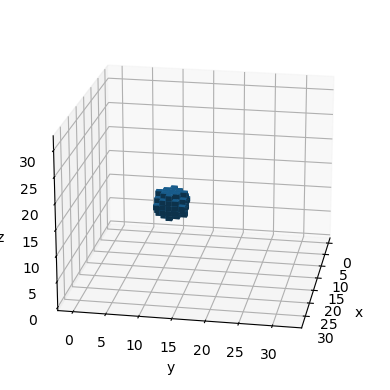

In [4]:
plot_voxel(ball_vxl)

In [5]:
X_all_anomalys = list()
radius_labels = list()
pos_ball = list()
vol_ball = list()

γ = 1  # set object geometries to 1 and empty space to 0
max_r = 4
for r in [2, 3, 4]:  # radius
    ball.r = r
    for x in np.linspace(boundary.x_0 + 2 * max_r, boundary.x_length - 2 * max_r, 20):
        for y in np.linspace(
            boundary.y_0 + 2 * max_r, boundary.y_length - 2 * max_r, 20
        ):
            for z in np.linspace(
                boundary.z_0 + 2 * max_r, boundary.z_length - 2 * max_r, 20
            ):
                ball = BallAnomaly(x, y, z, r, γ)
                vxl_ball = voxel_ball(ball, boundary)

                X_all_anomalys.append(vxl_ball)
                radius_labels.append(r)
                pos_ball.append([ball.y, ball.x, ball.z]) #  y,x,z in 3d Plot!!!
                vol_ball.append(np.where(vxl_ball == 1)[0].shape[0])

X_all_anomalys = np.array(X_all_anomalys)
radius_labels = np.array(radius_labels)
pos_ball = np.array(pos_ball)
vol_ball = np.array(vol_ball)

In [6]:
print(X_all_anomalys.shape, radius_labels.shape)

(24000, 32, 32, 32) (24000,)


In [7]:
(
    X_train,
    X_test,
    r_train,
    r_test,
    pos_train,
    pos_test,
    vol_train,
    vol_test,
) = train_test_split(
    X_all_anomalys,
    radius_labels,
    pos_ball,
    vol_ball,
    train_size=0.9,
    shuffle=True,
    random_state=42,
)

In [8]:
print(
    X_train.shape,
    X_test.shape,
    r_train.shape,
    r_test.shape,
    pos_train.shape,
    pos_test.shape,
    vol_train.shape,
    vol_test.shape,
)

(21600, 32, 32, 32) (2400, 32, 32, 32) (21600,) (2400,) (21600, 3) (2400, 3) (21600,) (2400,)


17756
Pos:	 [19.78947368 21.47368421 21.47368421]
Vol:	 36


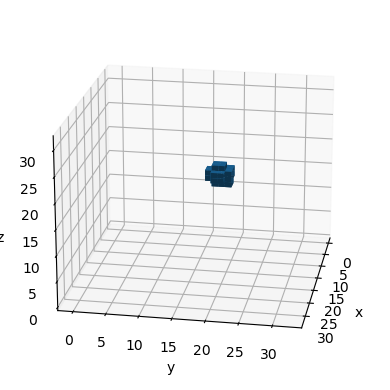

14382
Pos:	 [13.89473684 12.21052632 13.89473684]
Vol:	 30


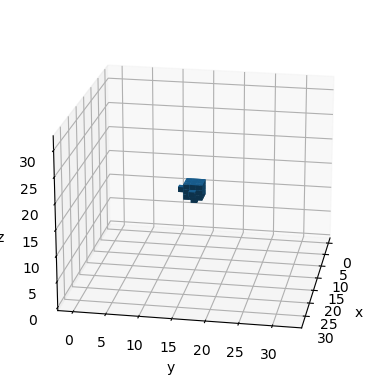

14229
Pos:	 [23.15789474 20.63157895 10.52631579]
Vol:	 35


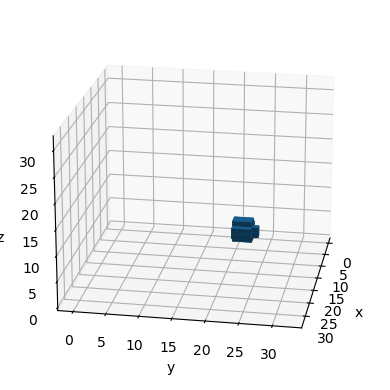

14669
Pos:	 [22.31578947  8.         16.42105263]
Vol:	 33


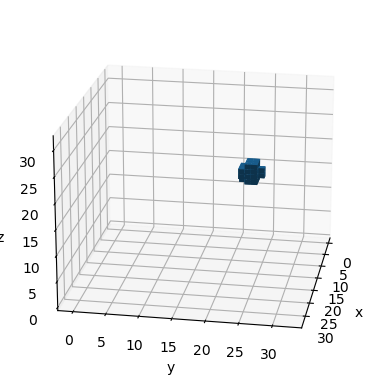

2224
Pos:	 [14.73684211  9.68421053 16.42105263]
Vol:	 267


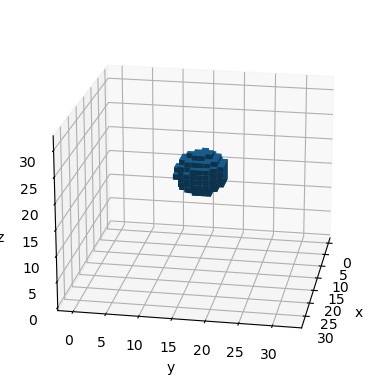

In [9]:
for rdn in np.random.randint(low=0, high=X_train.shape[0], size=5):
    print(rdn)
    print("Pos:\t", pos_train[rdn])
    print("Vol:\t", vol_train[rdn])
    plot_voxel_c(X_train[rdn, ...])

In [10]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.activations import sigmoid
from tensorflow.keras.backend import random_normal
from tensorflow.keras.layers import (
    BatchNormalization,
    Conv3D,
    Conv3DTranspose,
    Dense,
    Flatten,
    Input,
    Layer,
    Reshape,
)
from tensorflow.keras.losses import (
    binary_crossentropy,
    mean_absolute_error,
    mean_squared_error,
)
from tensorflow.keras.metrics import Mean
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

filters = [1, 2, 4, 8]
kernels = [(4, 4, 4), (4, 4, 4), (4, 4, 4), (4, 4, 4)]
strides = [(1, 1, 1), (2, 2, 2), (2, 2, 2), (2, 2, 2)]
paddings = ["same", "same", "same", "same"]

latent_dim = 8


class Sampling(Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


class VAE(Model):
    def __init__(self, encoder, decoder, beta=1.0, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.beta = beta
        self.total_loss_tracker = Mean(name="total_loss")
        self.reconstruction_loss_tracker = Mean(name="reconstruction_loss")
        self.kl_loss_tracker = Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
            self.total_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            kl_loss = 1 + z_log_var - tf.pow(z_mean, 2) - tf.exp(z_log_var)
            kl_loss = -0.5 * tf.reduce_sum(kl_loss, axis=-1)
            reconstruction_loss = binary_crossentropy(
                data, reconstruction, axis=(1, 2, 3)
            )  #
            reconstruction_loss *= np.prod((32, 32, 32, 1))
            # β-VAE
            # print("beta value:",self.beta)
            total_loss = reconstruction_loss + self.beta * kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
            "total_loss": self.total_loss_tracker.result(),
        }

    def get_config(self):
        config = super(VAE, self).get_config()
        config.update(
            {
                "encoder": tf.keras.utils.serialize_keras_object(self.encoder),
                "decoder": tf.keras.utils.serialize_keras_object(self.decoder),
                "beta": self.beta,
            }
        )
        return config


def encoder_model(
    input_shape=(32, 32, 32, 1),
    filters=filters,
    kernels=kernels,
    strides=strides,
    paddings=paddings,
    latent_dim=latent_dim,
):
    encoder_inputs = Input(shape=input_shape)
    x = BatchNormalization()(encoder_inputs)

    for fltr, krnl, strd, pddng in zip(filters, kernels, strides, paddings):
        x = Conv3D(
            filters=fltr,
            kernel_size=krnl,
            strides=strd,
            padding=pddng,
            activation="elu",
        )(x)
        x = BatchNormalization()(x)

    x = Flatten()(x)

    z_mean = Dense(latent_dim, name="z_mean", activation="sigmoid")(x)
    z_log_var = Dense(latent_dim, name="z_log_var")(x)
    z = Sampling()((z_mean, z_log_var))

    return encoder_inputs, z_mean, z_log_var, z


def decoder_model(
    input_shape=(32, 32, 32, 1),
    filters=filters[::-1],
    kernels=kernels[::-1],
    strides=strides[::-1],
    paddings=paddings[::-1],
    latent_dim=latent_dim,
):
    latent_inputs = Input(shape=(latent_dim,))
    x = Dense(512, activation="relu")(latent_inputs)
    x = Reshape((4, 4, 4, 8))(x)

    for fltr, krnl, strd, pddng in zip(filters, kernels, strides, paddings):
        x = Conv3DTranspose(
            filters=fltr,
            kernel_size=krnl,
            strides=strd,
            padding=pddng,
            activation="elu",
        )(x)
        x = BatchNormalization()(x)

    decoded = x

    return latent_inputs, decoded


def vae_model(
    input_shape=(32, 32, 32, 1),
    filters=filters,
    kernels=kernels,
    strides=strides,
    paddings=paddings,
    latent_dim=latent_dim,
    beta=1.0,
):
    encoder_inputs, z_mean, z_log_var, z = encoder_model(
        input_shape=(32, 32, 32, 1),
        filters=filters,
        kernels=kernels,
        strides=strides,
        paddings=paddings,
        latent_dim=latent_dim,
    )
    encoder = Model(encoder_inputs, (z_mean, z_log_var, z), name="VAE_encoder")

    decoder_inputs, decoder_outputs = decoder_model(
        input_shape=(32, 32, 32, 1),
        filters=filters[::-1],
        kernels=kernels[::-1],
        strides=strides[::-1],
        paddings=paddings[::-1],
        latent_dim=latent_dim,
    )
    decoder = Model(decoder_inputs, decoder_outputs, name="VAE_decoder")

    return VAE(encoder, decoder, beta=beta)


# engineering decoder and encoder parts:

encoder_inputs, z_mean, z_log_var, z = encoder_model(
    input_shape=(32, 32, 32, 1),
    filters=filters,
    kernels=kernels,
    strides=strides,
    paddings=paddings,
    latent_dim=latent_dim,
)
encoder = Model(encoder_inputs, (z_mean, z_log_var, z), name="VAE_encoder")

decoder_inputs, decoder_outputs = decoder_model(
    input_shape=(32, 32, 32, 1),
    filters=filters[::-1],
    kernels=kernels[::-1],
    strides=strides[::-1],
    paddings=paddings[::-1],
    latent_dim=latent_dim,
)
decoder = Model(decoder_inputs, decoder_outputs, name="VAE_decoder")

encoder.summary()
decoder.summary()

2024-04-25 06:41:51.892735: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-04-25 06:41:51.892839: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: 3a72e7669c6f
2024-04-25 06:41:51.892864: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: 3a72e7669c6f
2024-04-25 06:41:51.893037: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 470.141.3
2024-04-25 06:41:51.893081: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 470.141.3
2024-04-25 06:41:51.893098: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 470.141.3


Model: "VAE_encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 32, 1)]      0         []                            
                                                                                                  
 batch_normalization (Batch  (None, 32, 32, 32, 1)        4         ['input_1[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 conv3d (Conv3D)             (None, 32, 32, 32, 1)        65        ['batch_normalization[0][0]'] 
                                                                                                  
 batch_normalization_1 (Bat  (None, 32, 32, 32, 1)        4         ['conv3d[0][0]']    

In [ ]:
vae = vae_model(input_shape=(32, 32, 32, 1), beta=0.91)# 0.97

# learning_rate = 0.0001
# sgd = SGD(learning_rate = learning_rate_1, momentum = 0.9, nesterov = True)
# vae.compile(optimizer = SGD())# , metrics = ['accuracy']
vae.compile(optimizer=Adam())  # learning_rate = learning_rate

epochs = 100
batch_size = 200

# cb = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=0, start_from_epoch=47)

history = vae.fit(
    np.expand_dims(X_train, 4),
    epochs=epochs,
    batch_size=batch_size,
    # callbacks=[cb],
)

Epoch 1/100
108/108 [==============================] - 150s 1s/step - loss: 1023.5176 - reconstruction_loss: 917.1826 - kl_loss: 9.1721 - total_loss: 925.5294
Epoch 2/100
108/108 [==============================] - 145s 1s/step - loss: 828.5122 - reconstruction_loss: 792.4581 - kl_loss: 6.5529 - total_loss: 798.4213
Epoch 3/100
108/108 [==============================] - 144s 1s/step - loss: 733.0734 - reconstruction_loss: 716.3080 - kl_loss: 8.8915 - total_loss: 724.3990
Epoch 4/100
108/108 [==============================] - 144s 1s/step - loss: 728.0910 - reconstruction_loss: 717.2033 - kl_loss: 7.5096 - total_loss: 724.0367
Epoch 5/100
108/108 [==============================] - 144s 1s/step - loss: 673.5521 - reconstruction_loss: 597.4896 - kl_loss: 13.1867 - total_loss: 609.4894
Epoch 6/100
108/108 [==============================] - 143s 1s/step - loss: 474.7666 - reconstruction_loss: 445.5003 - kl_loss: 22.9653 - total_loss: 466.3988
Epoch 7/100
108/108 [============================

In [ ]:
vae_idx = len(glob.glob("models/vaes/*.h5"))
vae.save_weights(f"models/vaes/vae_{vae_idx}.weights.h5")

In [ ]:
for keys in history.history.keys():
    plt.plot(history.history[keys], label=keys)
    plt.legend()
plt.show()

Original...


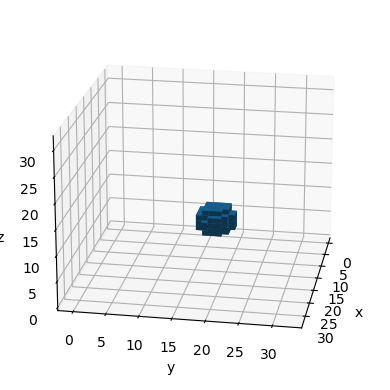

1/1 [==============================] - 0s 35ms/step
Prediction...


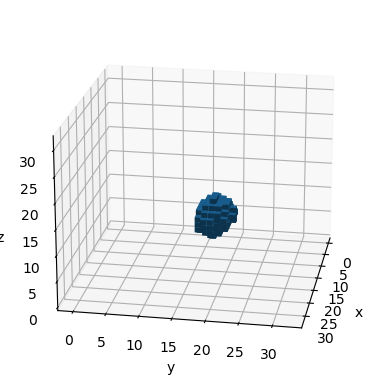

Original...


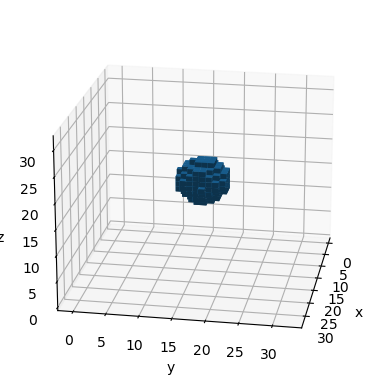

1/1 [==============================] - 0s 36ms/step
Prediction...


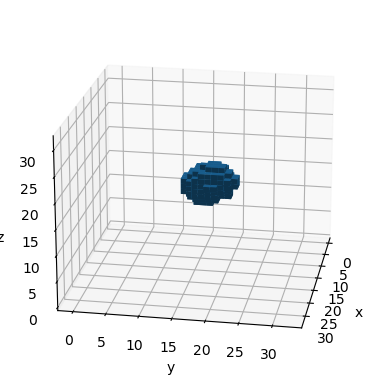

Original...


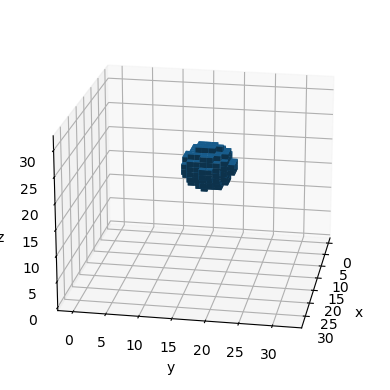

1/1 [==============================] - 0s 36ms/step
Prediction...


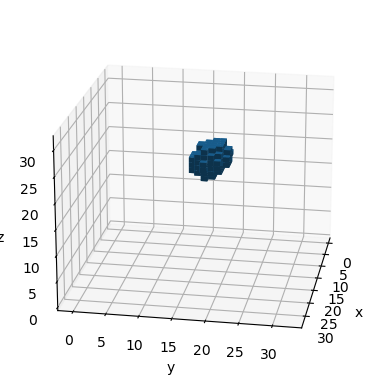

Original...


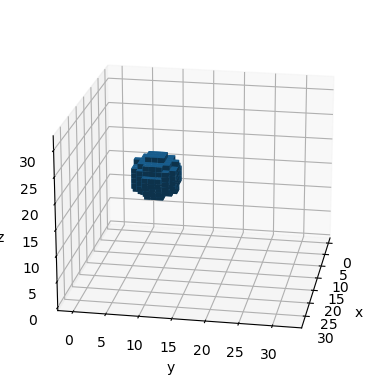

1/1 [==============================] - 0s 32ms/step
Prediction...


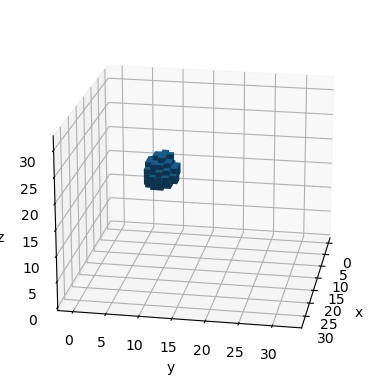

Original...


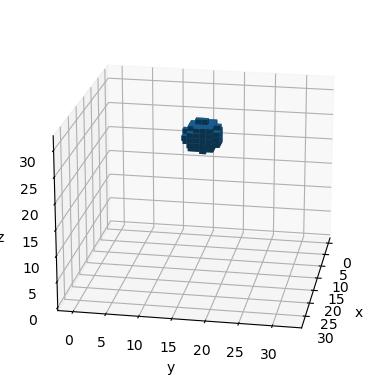

1/1 [==============================] - 0s 29ms/step
Prediction...


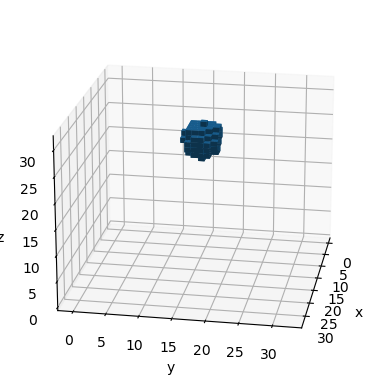

In [69]:
for rdn in np.random.randint(low=0, high=X_test.shape[0], size=5):
    print("Original...")
    plot_voxel(X_test[rdn, ...])
    _, _, z = vae.encoder.predict(np.expand_dims(X_test[rdn, ...], 0))
    sgl_pred = vae.decoder.predict(z)
    sgl_pred = np.squeeze(np.squeeze(sgl_pred, axis=4), axis=0)
    sgl_pred = np.clip(sgl_pred, a_min=0, a_max=1)
    sgl_pred = np.round(sgl_pred, 1) + 0.15  #  round offset
    sgl_pred = np.round(sgl_pred)

    print("Prediction...")
    plot_voxel(sgl_pred)

In [87]:
acc_measure = dict(Model=list(), Error_val=list(), Error=list(), test_idx = list())
# Apply test data to previously trained VAE
_, _, z = vae.encoder.predict(X_test)
X_pred = vae.decoder.predict(z)
X_pred = np.squeeze(X_pred, axis=4)
X_pred = np.clip(X_pred, a_min=0, a_max=1)
X_pred = np.round(X_pred, 1) + 0.15  #  round offset
X_pred = np.round(X_pred)


data_append = []

for idx, v_err in enumerate(compute_volume_error(X_pred, X_test)):
    v_percent = (v_err / 32**3) * 100
    data_append.append(dict(Model=vae_idx, Error_val=v_percent, Error="Volume", test_idx=idx))
    
for idx, p_err in enumerate(compute_position_error(pos_test, X_pred)):
    p_percent = (p_err/ np.linalg.norm(np.array([32,32,32]))) * 100
    data_append.append(dict(Model=vae_idx, Error_val=p_percent, Error="Position", test_idx=idx))
    
# Iterativ das Dictionary erweitern
for item in data_append:
    for key, value in item.items():
        acc_measure[key].append(value)

75/75 [==============================] - 9s 114ms/step


/home/jath/DD3D-EIT/src/performance_evaluation.py:16: RuntimeWarning: invalid value encountered in scalar divide
  center_x = np.sum(x_coords * voxel_matrix) / total_mass
/home/jath/DD3D-EIT/src/performance_evaluation.py:17: RuntimeWarning: invalid value encountered in scalar divide
  center_y = np.sum(y_coords * voxel_matrix) / total_mass
/home/jath/DD3D-EIT/src/performance_evaluation.py:18: RuntimeWarning: invalid value encountered in scalar divide
  center_z = np.sum(z_coords * voxel_matrix) / total_mass


In [89]:
acc_measure_df = pd.DataFrame(acc_measure).dropna()
acc_measure_df.to_csv(f"models/vaes/vae_acc_measure_{vae_idx}.csv", index=False)
acc_measure_df

,Model,Error_val,Error,test_idx
0,1,-0.100708,Volume,0
1,1,0.073242,Volume,1
2,1,0.064087,Volume,2
3,1,0.076294,Volume,3
4,1,-0.173950,Volume,4
...,...,...,...,...
4793,1,1.110039,Position,2393
4794,1,0.979525,Position,2394
4795,1,0.998310,Position,2395
4796,1,1.377600,Position,2396


Text(0, 0.5, 'Error (%)')

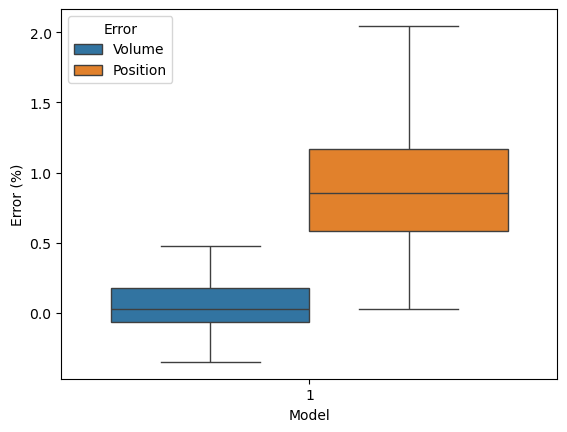

In [90]:
sns.boxplot(x = "Model", y="Error_val", data=acc_measure_df, hue="Error", showfliers=False) #  violinplot: , split=True
plt.ylabel("Error (%)")
#plt.xlabel("Model Iteration")

**Append Stats**

Text(0, 0.5, 'Error (%)')

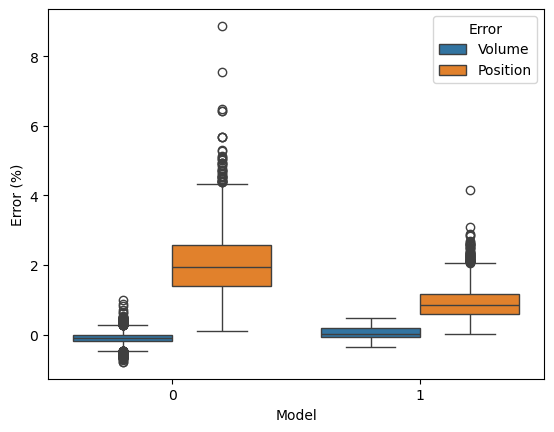

In [92]:
# Load all CSV files and concatenate them
combined_df = pd.concat([pd.read_csv(f_csvs) for f_csvs in glob.glob("models/vaes/vae_acc_measure_*.csv")], ignore_index=True)
combined_df = pd.DataFrame(combined_df)
sns.boxplot(x = "Model", y="Error_val", data=combined_df, hue="Error", showfliers=True) #  violinplot: , split=True
plt.ylabel("Error (%)")
#plt.xlabel("Model Iteration")

## Hyperparametertuning

In [10]:
import os

import numpy as np
from src.performance_evaluation import (
    center_of_mass,
    compute_voxel_error,
    visualize_errors,
)

In [12]:
hyperparameters = {
    "beta_s": np.linspace(0.9, 1.1, 3),
    "batch_s": [100, 200],
    "epoch_s": [50, 100],
    "savepath": "models/vae_hpt_4/",
}

In [13]:
try:
    os.mkdir(hyperparameters["savepath"])
except BaseException:
    print("[Errno 17] File exists")

In [14]:
np.savez(f"{hyperparameters['savepath']}vae_testdata.npz", X_test=X_test, r_test=r_test)

In [ ]:
for epoch in hyperparameters["epoch_s"]:
    for batch in hyperparameters["batch_s"]:
        for beta in hyperparameters["beta_s"]:
            print(f"{epoch=}, {batch=}, {beta=}")

            vae = vae_model(input_shape=(32, 32, 32, 1), beta=beta)
            vae.compile(optimizer=Adam())  # learning_rate = learning_rate

            history = vae.fit(
                np.expand_dims(X_train, 4),
                epochs=epoch,
                batch_size=batch,
            )
            # postprocessing and savings
            path = f"{hyperparameters['savepath']}ep_{epoch}_ba_{batch}_be_{int(10*np.round(beta,1))}"
            vae.save_weights(f"{path}.weights.h5")

            _, _, z = vae.encoder.predict(X_test)
            pred = vae.decoder.predict(z)
            pred = np.squeeze(pred, axis=4)
            pred = np.clip(pred, a_min=0, a_max=1)

            np.savez(
                f"{path}_saves.npz",
                history=history.history,
                hyperparameters=hyperparameters,
                epochs=epoch,
                batchs=batch,
                beta=beta,
                pred=pred,
            )

epoch=50, batch=100, beta=0.9


2024-04-23 06:41:02.081542: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-04-23 06:41:02.081630: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:134] retrieving CUDA diagnostic information for host: 3a72e7669c6f
2024-04-23 06:41:02.081653: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:141] hostname: 3a72e7669c6f
2024-04-23 06:41:02.081915: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:165] libcuda reported version is: 470.141.3
2024-04-23 06:41:02.081961: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:169] kernel reported version is: 470.141.3
2024-04-23 06:41:02.081983: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:248] kernel version seems to match DSO: 470.141.3


Epoch 1/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 114s 742ms/step - kl_loss: 5.8228 - loss: 1376.6586 - reconstruction_loss: 1370.6271 - total_loss: 1375.8674
Epoch 2/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 107s 721ms/step - kl_loss: 4.5089 - loss: 1148.8049 - reconstruction_loss: 1144.3396 - total_loss: 1148.3977
Epoch 3/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 107s 723ms/step - kl_loss: 21.0701 - loss: 827.3417 - reconstruction_loss: 807.4988 - total_loss: 826.4620
Epoch 4/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 107s 724ms/step - kl_loss: 30.2893 - loss: 503.8701 - reconstruction_loss: 476.7207 - total_loss: 503.9810
Epoch 5/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 107s 721ms/step - kl_loss: 28.3931 - loss: 407.3885 - reconstruction_loss: 381.8852 - total_loss: 407.4389
Epoch 6/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 106s 719ms/step - kl_loss: 29.1293 - loss: 426.3851 - reconstruction_loss: 399.9427 - total_loss: 426.1590
Epoch 7/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 106s 718ms/step - kl_loss: 41.1157 - loss: 716.0140 - reconstruction_loss:

## Further evaluation